In [1]:
from desispec.io import read_spectra
from desitrip.preproc import rebin_flux, rescale_flux

from glob import glob

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from astropy.table import Table

import os
import platform

mpl.rc('font', size=14)

## Input Spectra
Input DESI spectra, rebin and rescale them, and then divide them into training and test sets for the classifier.

In [2]:
def condition_spectra(coadd_files, truth_files):
    """Read DESI spectra, rebin to a subsampled logarithmic wavelength grid, and rescale.
    
    Parameters
    ----------
    coadd_files : list or ndarray
        List of FITS files on disk with DESI spectra.
    truth_files : list or ndarray
        Truth files.
    
    Returns
    -------
    fluxes : ndarray
        Array of fluxes rebinned to a logarithmic wavelength grid.
    """
    fluxes = None
    
    for cf, tf in zip(coadd_files, truth_files):
        spectra = read_spectra(cf)
        wave = spectra.wave['brz']
        flux = spectra.flux['brz']
        ivar = spectra.ivar['brz']
        
        truth = Table.read(tf, 'TRUTH')
        truez = truth['TRUEZ']

#         # Pre-condition: remove spectra with NaNs and zero flux values.
#         mask = np.isnan(flux).any(axis=1) | (np.count_nonzero(flux, axis=1) == 0)
#         mask_idx = np.argwhere(mask)
#         flux = np.delete(flux, mask_idx, axis=0)
#         ivar = np.delete(ivar, mask_idx, axis=0)

        # Rebin and rescale fluxes so that each is normalized between 0 and 1.
        rewave, reflux, reivar = rebin_flux(wave, flux, ivar, truez, minwave=2500., maxwave=9500., nbins=150, log=True, clip=True)
        rsflux = rescale_flux(reflux)

        if fluxes is None:
            fluxes = rsflux
        else:
            fluxes = np.concatenate((fluxes, rsflux))
    
    return fluxes

In [3]:
def brightness_cut(coadd_files, truth_files, percentile):
    fluxes = []
    ivars = []
    truezs = []
    ratios = []
    dim_SN_counter=0

    for cf, tf in zip(coadd_files, truth_files):
        spectra = read_spectra(cf)
        wave = spectra.wave['brz']
        flux = spectra.flux['brz']
        ivar = spectra.ivar['brz']

        truth = Table.read(tf, 'TRUTH')
        truez = truth['TRUEZ']
        objtruth = Table.read(tf, 'OBJTRUTH')
        ratio = objtruth['TRANSIENT_RFLUXRATIO']

        fluxes.append(flux)
        ivars.append(ivar)
        truezs.append(truez)
        ratios.append(ratio)


    fluxes=np.concatenate(np.asarray(fluxes))
    ivars=np.concatenate(np.asarray(ivars))
    truezs=np.concatenate(np.asarray(truezs))
    ratios=np.concatenate(np.asarray(ratios))
    bright_flux = []
    bright_ivar = []
    bright_truez = []


    for i in range(len(ratios)):
        if ratios[i]<percentile:
            dim_SN_counter+=1
        else:
            bright_flux.append(fluxes[i])
            bright_ivar.append(ivars[i])
            bright_truez.append(truezs[i])

    bright_flux=np.asarray(bright_flux)
    bright_ivar=np.asarray(bright_ivar)
    bright_truez=np.asarray(bright_truez)


    #         # Pre-condition: remove spectra with NaNs and zero flux values.
    #         mask = np.isnan(flux).any(axis=1) | (np.count_nonzero(flux, axis=1) == 0)
    #         mask_idx = np.argwhere(mask)
    #         flux = np.delete(flux, mask_idx, axis=0)
    #         ivar = np.delete(ivar, mask_idx, axis=0)

    # Rebin and rescale fluxes so that each is normalized between 0 and 1.
    rewave, reflux, reivar = rebin_flux(wave, bright_flux, bright_ivar, bright_truez, minwave=2500., maxwave=9500., nbins=150, log=True, clip=True)
    rsflux = rescale_flux(reflux)
    
    return rsflux

In [4]:
host_truth = sorted(glob('hosts/*truth.fits'))
host_coadd = sorted(glob('hosts/*coadd.fits'))
host_flux  = condition_spectra(host_coadd, host_truth)

In [5]:
snia_truth = sorted(glob('sneia/*truth.fits'))
snia_files = sorted(glob('sneia/*coadd.fits'))
snia_flux  = brightness_cut(snia_files, snia_truth, 0)

In [6]:
nhost, nbins = host_flux.shape
nsnia, nbins = snia_flux.shape

nhost, nsnia, nbins

(9969, 9964, 150)

In [7]:
#Get data transient rflux ratio, transient host redshift, transient host rmag, transient phase
import math

flux_ratio = []
host_redshift = []
host_rmag = []
phase = []

bad_counter = 0
coadd_files = sorted(glob('sneia/*coadd.fits'))
truth_files = sorted(glob('sneia/*truth.fits'))

for cf, tf in zip(coadd_files, truth_files):
    spectra = read_spectra(cf)
    wave = spectra.wave['brz']
    flux = spectra.flux['brz']

    truth = Table.read(tf, 'TRUTH')
    truez = truth['TRUEZ']
    mag = truth['MAG']
    
    objtruth = Table.read(tf, 'OBJTRUTH')
    ratio = objtruth['TRANSIENT_RFLUXRATIO']
    epoch = objtruth['TRANSIENT_EPOCH']
    
    for i in range(100):
        if np.sum(flux[i])==0 or math.isnan(np.sum(flux[i])):
            bad_counter+=1
        else:
            flux_ratio.append(ratio[i])
            host_redshift.append(truez[i])
            host_rmag.append(mag[i])
            phase.append(epoch[i])
            
flux_ratio=np.asarray(flux_ratio)
host_redshift=np.asarray(host_redshift)
host_rmag=np.asarray(host_rmag)
phase=np.asarray(phase)

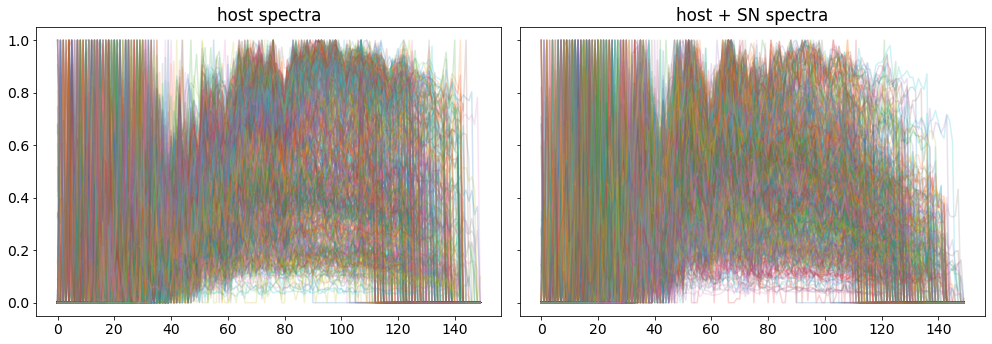

In [8]:
fig, axes = plt.subplots(1,2, figsize=(14,5), sharex=True, sharey=True)

for i in range(0,500):
    
    ax = axes[0]
    ax.plot(host_flux[i], alpha=0.2)

    ax = axes[1]
    ax.plot(snia_flux[i], alpha=0.2)
    
axes[0].set_title('host spectra')
axes[1].set_title('host + SN spectra')

fig.tight_layout()

In [9]:
x = np.concatenate([host_flux, snia_flux]).reshape(-1, nbins, 1)
y = np.concatenate([np.zeros(nhost), np.ones(nsnia)])

In [10]:
import tensorflow as tf
from tensorflow.keras import utils, regularizers, callbacks, backend
from tensorflow.keras.layers import Input, Dense, Activation, ZeroPadding1D, BatchNormalization, Flatten, Reshape, Conv1D, MaxPooling1D, Dropout, Add, LSTM, Embedding
from tensorflow.keras.initializers import glorot_normal, glorot_uniform
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, load_model

/software/python3/3.6.5/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/software/python3/3.6.5/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/software/python3/3.6.5/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/software/python3/3.6.5/lib/python3.6/site-packages/tensorflow/python/framework

In [11]:
def network(input_shape, learning_rate=0.0005, reg=0.0032, dropout=0.7436, seed=None):
    """Define the CNN structure.
    
    Parameters
    ----------
    input_shape : int
        Shape of the input spectra.
    learning_rate : float
        Learning rate.
    reg : float
        Regularization factor.
    dropout : float
        Dropout rate.
    seed : int
        Seed of initializer.
    
    Returns
    -------
    model : tensorflow.keras.Model
        A model instance of the network.
    """
    X_input = Input(input_shape, name='Input_Spec')
    
    X_input = Input(input_shape, name='Input_Spec')

    # First convolutional layer.
    with backend.name_scope('Conv_1'):
        X = Conv1D(filters=8, kernel_size=5, strides=1, padding='same',
                   kernel_regularizer=regularizers.l2(reg),
                   bias_initializer='zeros',
                   kernel_initializer=glorot_normal(seed))(X_input)
        X = BatchNormalization(axis=2)(X)
        X = Activation('relu')(X)
        X = MaxPooling1D(pool_size= 2)(X)

    # Second convolutional layer.
    with backend.name_scope('Conv_2'):
        X = Conv1D(filters=16, kernel_size=5, strides=1, padding='same',
                   kernel_regularizer=regularizers.l2(reg),
                   bias_initializer='zeros',
                   kernel_initializer=glorot_normal(seed))(X)
        X = BatchNormalization(axis=2)(X)
        X = Activation('relu')(X)
        X = MaxPooling1D(2)(X)
        
    # Third convolutional layer.
    with backend.name_scope('Conv_3'):
        X = Conv1D(filters=32, kernel_size=5, strides=1, padding='same',
                   kernel_regularizer=regularizers.l2(reg),
                   bias_initializer='zeros',
                   kernel_initializer=glorot_normal(seed))(X)
        X = BatchNormalization(axis=2)(X)
        X = Activation('relu')(X)
        X = MaxPooling1D(2)(X)
        
    # Fourth convolutional layer.
    with backend.name_scope('Conv_4'):
        X = Conv1D(filters=64, kernel_size=5, strides=1, padding='same',
                   kernel_regularizer=regularizers.l2(reg),
                   bias_initializer='zeros',
                   kernel_initializer=glorot_normal(seed))(X)
        X = BatchNormalization(axis=2)(X)
        X = Activation('relu')(X)
        X = MaxPooling1D(2)(X)

    # Flatten to fully connected dense layer.
    with backend.name_scope('Dense_Layer'):
        X = Flatten()(X)
        X = Dense(256, kernel_regularizer=regularizers.l2(reg),
                  activation='relu')(X)
        X = Dropout(rate=dropout, seed=seed)(X)
    
    # Output layer with sigmoid activation.
    with backend.name_scope('Output_Layer'):
        X = Dense(1, kernel_regularizer=regularizers.l2(reg),
              activation='sigmoid',name='Output_Classes')(X)

    model = Model(inputs=X_input, outputs=X, name='SNnet')
    
    # Set up optimizer, loss function, and optimization metrics.
    model.compile(optimizer=Adam(lr=learning_rate), loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [12]:
model = network((nbins, 1))

In [13]:
from sklearn.model_selection import train_test_split

indices = np.arange(len(x))

x_train, x_test, y_train, y_test,id_train,id_test = train_test_split(x, y, indices, test_size=0.25)
hist = model.fit(x_train, y_train, batch_size=65, epochs=50, validation_data=(x_test, y_test), shuffle=True)

Train on 14949 samples, validate on 4984 samples
Epoch 1/50
14949/14949 [==============================] - 9s 599us/step - loss: 1.5775 - acc: 0.7208 - val_loss: 1.3461 - val_acc: 0.7257
Epoch 2/50
14949/14949 [==============================] - 8s 527us/step - loss: 1.0324 - acc: 0.8225 - val_loss: 0.9239 - val_acc: 0.8204
Epoch 3/50
14949/14949 [==============================] - 7s 498us/step - loss: 0.8015 - acc: 0.8479 - val_loss: 0.7214 - val_acc: 0.8591
Epoch 4/50
14949/14949 [==============================] - 8s 522us/step - loss: 0.6636 - acc: 0.8580 - val_loss: 0.6066 - val_acc: 0.8632
Epoch 5/50
14949/14949 [==============================] - 7s 500us/step - loss: 0.5687 - acc: 0.8701 - val_loss: 0.5486 - val_acc: 0.8648
Epoch 6/50
14949/14949 [==============================] - 7s 500us/step - loss: 0.5062 - acc: 0.8760 - val_loss: 0.4867 - val_acc: 0.8734
Epoch 7/50
14949/14949 [==============================] - 7s 499us/step - loss: 0.4611 - acc: 0.8806 - val_loss: 0.4563 - v

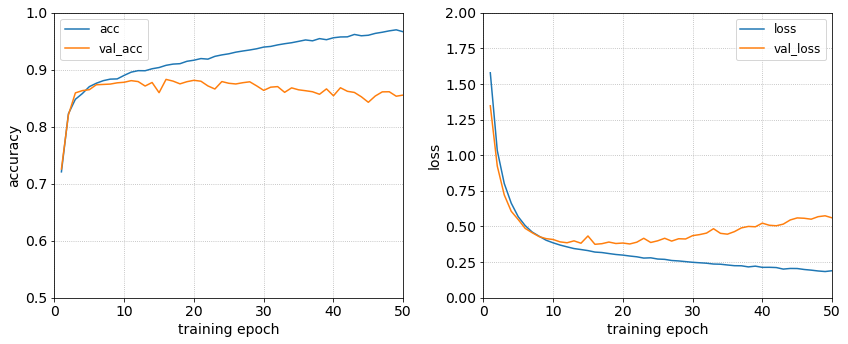

In [14]:
fig, axes = plt.subplots(1,2, figsize=(12,5), sharex=True)

nepoch = len(hist.history['loss'])
epochs = np.arange(1, nepoch+1)

ax = axes[0]
ax.plot(epochs, hist.history['acc'], label='acc')
ax.plot(epochs, hist.history['val_acc'], label='val_acc')
ax.set(xlabel='training epoch',
       ylabel='accuracy',
       xlim=(0, nepoch),
       ylim=(0.5,1.0))
ax.legend(fontsize=12, loc='best')
ax.grid(ls=':')

ax = axes[1]
ax.plot(epochs, hist.history['loss'], label='loss')
ax.plot(epochs, hist.history['val_loss'], label='val_loss')
ax.set(xlabel='training epoch',
       ylabel='loss',
       xlim=(0, nepoch),
       ylim=(0.,2.0))
ax.legend(fontsize=12, loc='best')
ax.grid(ls=':')

fig.tight_layout();

In [15]:
y_pred = model.predict(x_test).ravel()

In [16]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

fpr, tpr, thresholds = roc_curve(y_test, y_pred)
pre, rec, _ = precision_recall_curve(y_test, y_pred)

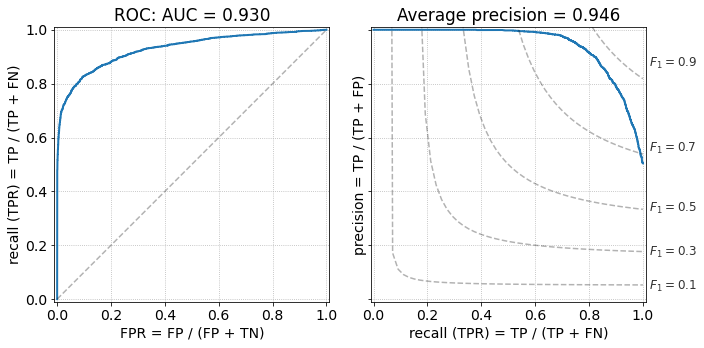

In [17]:
fig, axes = plt.subplots(1,2, figsize=(10,5), sharex=True, sharey=True)

ax = axes[0]
ax.plot(fpr, tpr, lw=2)
ax.plot((0,1), (0,1), 'k--', alpha=0.3)
ax.grid(ls=':')
ax.set(xlim=(-0.01,1.01), xlabel='FPR = FP / (FP + TN)',
       ylim=(-0.01,1.01), ylabel='recall (TPR) = TP / (TP + FN)',
       title='ROC: AUC = {:.3f}'.format(auc(fpr, tpr)),
       aspect='equal')

ax = axes[1]
ax.plot(rec, pre, lw=2)
f_scores = np.linspace(0.1, 0.9, num=5)
lines = []
labels = []
for f_score in f_scores:
    x_ = np.linspace(0.01, 1)
    y_ = f_score * x_ / (2 * x_ - f_score)
    l, = plt.plot(x_[y_ >= 0], y_[y_ >= 0], color='k', ls='--', alpha=0.3)
    ax.annotate(' $F_{{1}}={0:0.1f}$'.format(f_score), xy=(1.01, y_[45]-0.02),
                fontsize=12, alpha=0.8)
ax.grid(ls=':')
ax.set(xlabel='recall (TPR) = TP / (TP + FN)',
       ylabel='precision = TP / (TP + FP)',
       title='Average precision = {:.3f}'.format(average_precision_score(y_test, y_pred)),
       aspect='equal')

fig.tight_layout()

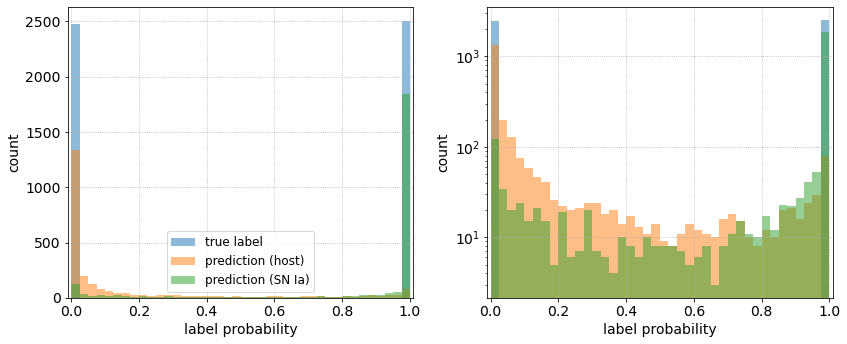

In [18]:
fig, axes = plt.subplots(1,2, figsize=(12,5), sharex=True)

ax = axes[0]
ybins = np.linspace(0,1,41)
ax.hist(y_test, bins=ybins, alpha=0.5, label='true label')
ax.hist(y_pred[y_test==0], bins=ybins, alpha=0.5, label='prediction (host)')
ax.hist(y_pred[y_test==1], bins=ybins, alpha=0.5, label='prediction (SN Ia)')
ax.grid(ls=':')
ax.set(xlabel='label probability',
       xlim=(-0.01, 1.01),
       ylabel='count')
ax.legend(fontsize=12, loc='best')

ax = axes[1]
ybins = np.linspace(0,1,41)
ax.hist(y_test, bins=ybins, alpha=0.5, label='true label')
ax.hist(y_pred[y_test==0], bins=ybins, alpha=0.5, label='prediction (host)')
ax.hist(y_pred[y_test==1], bins=ybins, alpha=0.5, label='prediction (SN Ia)', log=True)
ax.grid(ls=':')
ax.set(xlabel='label probability',
       xlim=(-0.01, 1.01),
       ylabel='count')

fig.tight_layout()

In [19]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred > 0.5)
cmnorm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

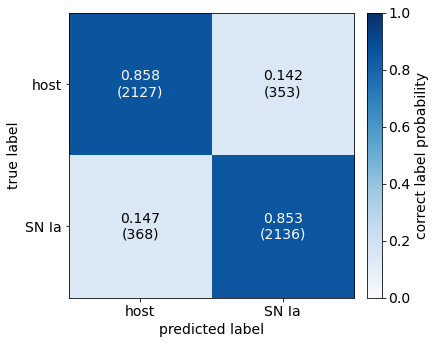

In [20]:
fig, ax = plt.subplots(1,1, figsize=(6,5))

im = ax.imshow(cmnorm, cmap='Blues', vmin=0, vmax=1)
cb = ax.figure.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cb.set_label('correct label probability')

ax.set(aspect='equal',
       xlabel='predicted label',
       xticks=np.arange(cm.shape[1]),
       xticklabels=['host', 'SN Ia'],
       ylabel='true label',
       yticks=np.arange(cm.shape[1]),
       yticklabels=['host', 'SN Ia'])

thresh = 0.5*cm.max()
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, '{:.3f}\n({:d})'.format(cmnorm[i,j], cm[i,j]),
                ha='center', va='center',
                color='black' if cm[i,j] < thresh else 'white')

fig.tight_layout()

In [31]:
flux_ratio_test = []
for i in id_test:
    if i>len(host_flux):
        flux_ratio_test.append(flux_ratio[i-len(host_flux)])
        
flux_ratio_test=np.asarray(flux_ratio_test)

In [23]:
SN_score = []
for i in range(len(y_pred)):
    if y_test[i]==1:
        SN_score.append(y_pred[i])
        
SN_score=np.asarray(SN_score)

Text(0, 0.5, 'score')

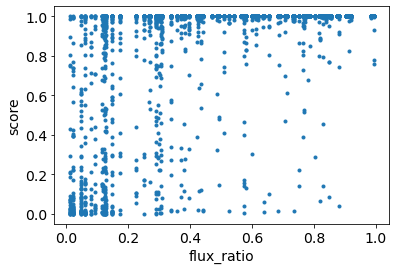

In [51]:
plt.plot(flux_ratio_test,SN_score,'.')
plt.xlabel('flux_ratio')
plt.ylabel('score')

In [37]:
phase_test = []
for i in id_test:
    if i>len(host_flux):
        phase_test.append(phase[i-len(phase)])
        
phase_test=np.asarray(phase_test)

Text(0, 0.5, 'score')

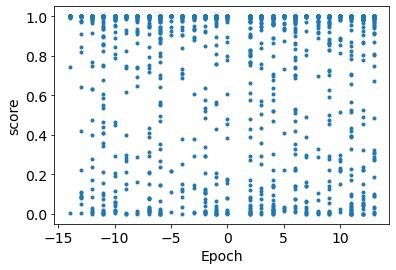

In [50]:
plt.plot(phase_test,SN_score,'.')
plt.xlabel('Epoch')
plt.ylabel('score')

In [42]:
host_redshift_test = []
for i in id_test:
    if i>len(host_flux):
        host_redshift_test.append(host_redshift[i-len(host_redshift)])
        
host_redshift_test=np.asarray(host_redshift_test)

Text(0, 0.5, 'score')

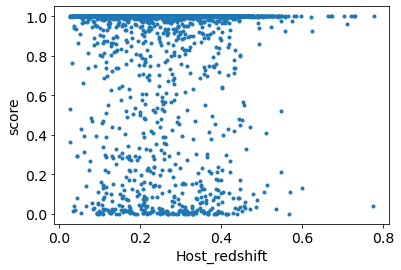

In [46]:
plt.plot(host_redshift_test,SN_score,'.')
plt.xlabel('Host_redshift')
plt.ylabel('score')

In [47]:
host_rmag_test = []
for i in id_test:
    if i>len(host_flux):
        host_rmag_test.append(host_rmag[i-len(host_rmag)])
        
host_rmag_test=np.asarray(host_rmag_test)

Text(0, 0.5, 'score')

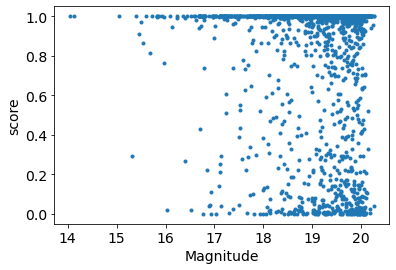

In [49]:
plt.plot(host_rmag_test,SN_score,'.')
plt.xlabel('Magnitude')
plt.ylabel('score')

In [52]:
import numpy as np, pandas as pd; np.random.seed(0)
import seaborn as sns; sns.set(style="white", color_codes=True)

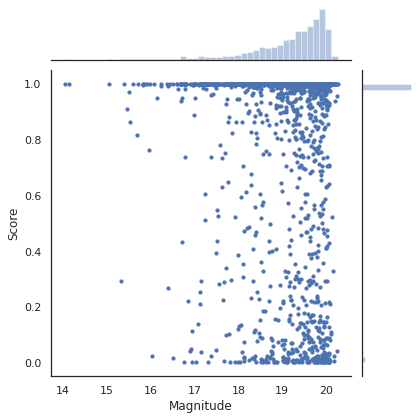

In [72]:
d = {'Magnitude': host_rmag_test, 'Score': SN_score}
data = pd.DataFrame(data=d)
data

g = sns.jointplot(x="Magnitude", y="Score",data=data,s=10)


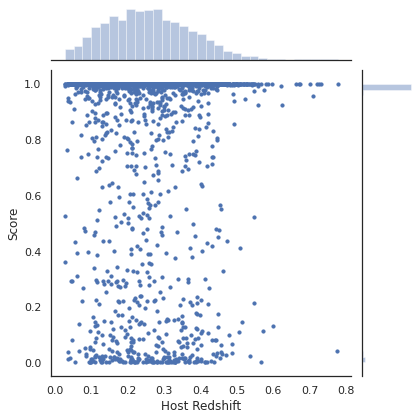

In [80]:
d = {'Host Redshift': host_redshift_test, 'Score': SN_score}
data = pd.DataFrame(data=d)
data

g = sns.jointplot(x="Host Redshift", y="Score",data=data,s=10)


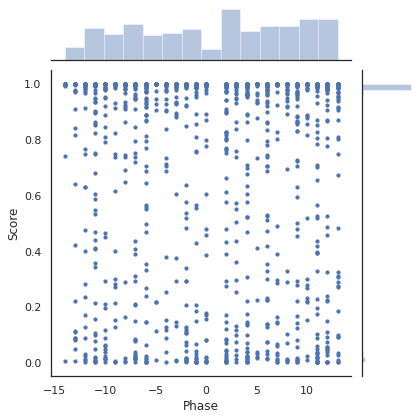

In [76]:
d = {'Phase': phase_test, 'Score': SN_score}
data = pd.DataFrame(data=d)
data

g = sns.jointplot(x="Phase", y="Score",data=data,s=10)


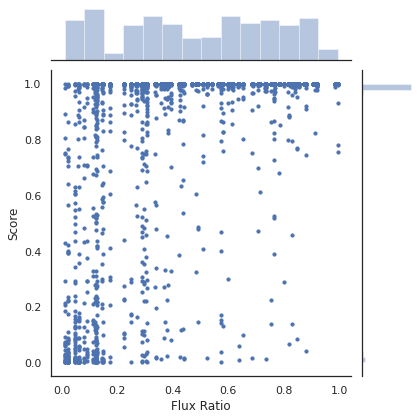

In [77]:
d = {'Flux Ratio': flux_ratio_test, 'Score': SN_score}
data = pd.DataFrame(data=d)
data

g = sns.jointplot(x="Flux Ratio", y="Score",data=data,s=10)
